# Instant-ngp

This notebook aims to be a step-by-step guide to train NeRF models and rendering videos from them with nvidia's [instant-ngp](https://github.com/NVlabs/instant-ngp) software using:
 * **Colab** for the heavy lifting.
 * A low-resource **local computer** for the steps that require having a graphical user interface (GUI).

It has been tested on a GTX 1050ti in the local machine and an assigned Tesla T4 in the remote one.

Based on this [notebook](https://colab.research.google.com/drive/10TgQ4gyVejlHiinrmm5XOvQQmgVziK3i?usp=sharing) by [@myagues](https://github.com/NVlabs/instant-ngp/issues/6#issuecomment-1016397579), the main differences being the addition of steps 3 and 4 to ensure compatibility between the local machine and the models trained in the remote machine, of step 10 to render a video from the scene, and a more guided approach.

## 1.Connect to a GPU runtime

Connect your colab session to a GPU runtime and check that you have been assigned a GPU. It should have a minimum of 8GB of available memory.

In [27]:
!nvidia-smi

Tue Jul  4 11:28:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Install dependencies and clone the instant-ngp repo

In [28]:
!apt update && apt install build-essential git python3-dev python3-pip libopenexr-dev libxi-dev libglfw3-dev libglew-dev libomp-dev libxinerama-dev libxcursor-dev colmap ffmpeg jq
!pip install --upgrade cmake

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [81.0 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,079 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:13 http://security.ubuntu.com/ubuntu fo

In [29]:
!git clone --recursive https://github.com/nvlabs/instant-ngp
%cd instant-ngp

Cloning into 'instant-ngp'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 4154 (delta 21), reused 28 (delta 14), pack-reused 4100
Receiving objects: 100% (4154/4154), 186.90 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (2649/2649), done.
Updating files: 100% (368/368), done.
Submodule 'dependencies/OpenXR-SDK' (https://github.com/KhronosGroup/OpenXR-SDK.git) registered for path 'dependencies/OpenXR-SDK'
Submodule 'dependencies/args' (https://github.com/Taywee/args) registered for path 'dependencies/args'
Submodule 'dependencies/dlss' (https://github.com/NVIDIA/DLSS) registered for path 'dependencies/dlss'
Submodule 'dependencies/glfw' (https://github.com/Tom94/glfw) registered for path 'dependencies/glfw'
Submodule 'dependencies/glm' (https://github.com/g-truc/glm) registered for path 'dependencies/glm'
Submodule 'dependencies/imgui' (https://github.com/ocornut/imgui.git) regist

## 3. Set compute capability
Find the compute capability of the GPU in your **local** machine in the following link:
https://developer.nvidia.com/cuda-gpus

You need this to be able to open your trained models in `testbed` inside your local machine later on, so you can explore them or trace a camera path in order to generate a video from your scene.

In [30]:
compute_capability = "61" #@param [50, 52, 60, 61, 70, 72, 75, 80, 86, 87]
%env TCNN_CUDA_ARCHITECTURES=$compute_capability


env: TCNN_CUDA_ARCHITECTURES=61


## 4. Set the right network configuration
For compatibility between the model trained here and the local machine, a network with FP32 or FP16 is chosen.

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix

In [31]:
network_type = "FullyFusedMLP" if int(compute_capability) >= 70 else "CutlassMLP"
print(f"Using {network_type}")
%env NN_CONFIG_PATH = ./configs/nerf/base.json
!jq '.network.otype = "CutlassMLP" | .rgb_network.otype = "CutlassMLP"' $NN_CONFIG_PATH | sponge $NN_CONFIG_PATH

Using CutlassMLP
env: NN_CONFIG_PATH=./configs/nerf/base.json


## 5. Build the project and install python requirements

In [32]:
!cmake . -B build -DNGP_BUILD_WITH_GUI=OFF

-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- The CUDA compiler identification is NVIDIA 11.8.89
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- No release type specified. Setting to 'Release'.
-- Obtained CUDA architectures from environment variable TCNN_CUDA_ARCHITECTURES=61
-- Targeting CUDA architectures: 61
CMake Warning at dependencies/tiny-cuda-nn/C

In [33]:
!cmake --build build --config RelWithDebInfo -j `nproc`

[  2%] Building CUDA object CMakeFiles/optix_program.dir/src/optix/pathescape.ptx
[  5%] Building CXX object dependencies/tiny-cuda-nn/dependencies/fmt/CMakeFiles/fmt.dir/src/format.cc.o
[  7%] Building CXX object dependencies/tiny-cuda-nn/dependencies/fmt/CMakeFiles/fmt.dir/src/os.cc.o
[ 10%] Building CUDA object CMakeFiles/optix_program.dir/src/optix/raystab.ptx
[ 12%] Linking CXX static library libfmt.a
[ 12%] Built target fmt
[ 15%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/common.cu.o
[ 17%] Building CUDA object CMakeFiles/optix_program.dir/src/optix/raytrace.ptx
[ 20%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/common_device.cu.o
[ 20%] Built target optix_program
[ 23%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/cpp_api.cu.o
[ 25%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/cutlass_mlp.cu.o
[ 28%] Building CUDA object dependencies/tiny-c

In [34]:
!pip3 install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.2/276.2 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for commentjson: filename=commentjson-0.9.0-py3-none-any.whl size=12075 sha256=8ddab132aebaf2b10b5d873947618d1ee90d5560511c21a7e40111f8fb2341b7
  Stored in directory: /root/.cache/pip/wheels/7d/90/23/6358a234ca5b4ec0866d447079b97fedf9883387d1d7d074e5
  Created wheel for lark-parser: filename=lark_parser-0.7.8-py2.py3-none-any.whl size=62510 sha256=5fc8b4475c900646a031b22b32e5d7095fec6d415906d033d7609362764ab1dc
  Stored in directory: /root/.cache/pip/wheels/29/30/94/33e8b58318aa05cb1842b365843036e0280af5983abb966b83
Successfully built commentjson lark-parser


## 6. [LOCAL MACHINE] Run COLMAP on your scene
COLMAP doesn't work on machines without a GUI.

Go to your local machine and follow the [instructions](https://github.com/NVlabs/instant-ngp/blob/master/docs/nerf_dataset_tips.md#preparing-new-nerf-datasets) to run COLMAP from a video or a set of images to generate camera positions from your scene.

After this, you should have an images folder, with the images of your scene, and a `transforms.json` file with the camera information extracted by COLMAP.

## 7. Upload your scene

Mount your google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then upload the `images` folder and the output of COLMAP, `transforms.json`, to your drive. The structure should be similar to the following:
```
/content/drive/MyDrive/nerf_scenes/
└── fox
    ├── images
    │   ├── 00001.jpg
    │   └── 00002.jpg
    └── transforms.json
```



Enter the path to your scene

In [35]:
import os
scene_path = "/content/drive/MyDrive/q1/finalDataset/train" #@param {type:"string"}ent/drive/MyD
if not os.path.isdir(scene_path):
  raise NotADirectoryError(scene_path)

## 8. Train a model on your scene!

In [ ]:
train_steps = 10000  #@param {type:"integer"}
snapshot_path = os.path.join(scene_path, f"ngp_model.ingp")
!python ./scripts/run.py {scene_path} --n_steps {train_steps} --save_snapshot {snapshot_path}

12:50:39 SUCCESS  Initialized CUDA. Active GPU is #0: Tesla T4 [75]
12:50:39 INFO     Loading NeRF dataset from
12:50:40 INFO       /content/drive/MyDrive/q1/finalDataset/train/transforms.json
12:50:40 PROGRESS []   0% (  0/100)  0s/inf12:50:40 PROGRESS []   1% (  1/100) 0s/0s12:50:40 PROGRESS []   2% (  2/100) 0s/0s12:50:40 PROGRESS []   3% (  3/100) 0s/0s12:50:40 PROGRESS []   4% (  4/100) 0s/0s12:50:40 PROGRESS []   5% (  5/100) 0s/0s12:50:40 PROGRESS []   6% (  6/100) 0s/0s12:50:40 PROGRESS []   7% (  7/100) 0s/0s12:50:40 PROGRESS []   8% (  8/100) 0s/0s12:50:40 PROGRESS []   9% (  9/100) 0s/0s12:50:40 PROGRESS []  10% ( 10/100) 0s/0s12:50:40 PROGRESS []  11% ( 11/100) 0s/0s12:50:40 PROGRESS []  12% ( 12/100) 0s/3s12:50:40 PROGRESS []  13% ( 13/100) 0s/2s12:50:41 PROGRESS []  14% ( 14/100) 0s/5s12:50:41 PROGRESS []  15% ( 15/100) 0s/4s12:50:41 PROGRESS []  16% ( 16/100) 1s/6s12:50:41 PROGRESS []  17% ( 17/100) 1s/6s12:50:41 PROGRESS []  18% ( 18/100) 1s/7s12:50:41 PROGRESS []  19% 

## 9. [LOCAL MACHINE] Generate a camera path

Congrats! You now have a trained nerf checkpoint. Now, in order to generate a video with it, you will need to open it in your local machine with `testbed` and generate a `base_cam.jon` file following these [instructions](https://github.com/NVlabs/instant-ngp#testbed-controls). Remember to launch with the `--no-train` argument so that it doesn't start to train on your PC. Setting up the cameras can make your GUI pretty laggy, you can try to play with the `--height` and `--width` parameters or cropping your scene with the `Crop aabb` options to optimize the performance.

Example command:
```
./build/instant-ngp /data/nerf/fox/2000.ingp
```

After you're done, **upload `base_cam.json` to the root folder of your scene.**

## 11. Render screenshots

In [36]:
tests_path = "/content/drive/MyDrive/q1/finalDataset/test/video.json"
screenshots_path = "/content/drive/MyDrive/q1/finalDataset/test/ngp/video/"
snapshot_path = os.path.join(scene_path, f"ngp_model.ingp")
print(screenshots_path)

/content/drive/MyDrive/q1/finalDataset/test/ngp/video/


In [37]:
!python scripts/run.py --scene {scene_path} --mode nerf --load_snapshot {snapshot_path} --screenshot_transforms {tests_path}  --screenshot_dir {screenshots_path} --width 256 --height 256 --n_steps 0
print(f"Generated screenshots saved to:\n{screenshots_path}")

11:43:43 SUCCESS  Initialized CUDA. Active GPU is #0: Tesla T4 [75]
11:43:43 INFO     Loading NeRF dataset from
11:43:44 INFO       /content/drive/MyDrive/q1/finalDataset/train/transforms.json
11:43:44 PROGRESS []   0% (  0/100)  0s/inf11:43:44 PROGRESS []   1% (  1/100) 0s/0s11:43:44 PROGRESS []   2% (  2/100) 0s/0s11:43:44 PROGRESS []   3% (  3/100) 0s/0s11:43:44 PROGRESS []   4% (  4/100) 0s/0s11:43:44 PROGRESS []   5% (  5/100) 0s/0s11:43:44 PROGRESS []   6% (  6/100) 0s/0s11:43:44 PROGRESS []   7% (  7/100) 0s/0s11:43:44 PROGRESS []   8% (  8/100) 0s/0s11:43:44 PROGRESS []   9% (  9/100) 0s/0s11:43:44 PROGRESS []  10% ( 10/100) 0s/0s11:43:44 PROGRESS []  11% ( 11/100) 0s/0s11:43:44 PROGRESS []  12% ( 12/100) 0s/0s11:43:44 PROGRESS []  13% ( 13/100) 0s/0s11:43:44 PROGRESS []  14% ( 14/100) 0s/0s11:43:44 PROGRESS []  15% ( 15/100) 0s/0s11:43:44 PROGRESS []  16% ( 16/100) 0s/0s11:43:44 PROGRESS []  17% ( 17/100) 0s/0s11:43:44 PROGRESS []  18% ( 18/100) 0s/0s11:43:44 PROGRESS []  19% 

## 12. Test similarity

In [2]:
!pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10583 sha256=e3e466fb5786fd9c0586bf9f9fc2fb7919545584e6b748ee24e9a72a97750bc3
  Stored in directory: /root/.cache/pip/wheels/06/71/a0/ce363fc3bc7374b69963c517c1f570358f46e881cee13ae5b6
Successfully built sewar


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sewar.full_ref import mse, ssim

In [18]:
import os
testImages = "/content/drive/MyDrive/q1/finalDataset/test/torch/test/"
trainingImages = "/content/drive/MyDrive/q1/finalDataset/test/torch/train/"
trueTestImages = "/content/drive/MyDrive/q1/finalDataset/test/images/"
trueTrainImages = "/content/drive/MyDrive/q1/finalDataset/train/images/"

In [19]:
trainingNames = ["image5.png", "image16.png", "image26.png", "image32.png", "image40.png", "image58.png", "image67.png", "image78.png", "image89.png", "image99.png"]
trainingIndexes = [5, 16, 26, 32, 40, 58, 67, 78, 89, 99]

In [20]:
testImages = [os.path.join(testImages, file) for file in os.listdir(trueTestImages)]
trainingImages = [os.path.join(trainingImages, file) for file in os.listdir(trueTrainImages)]
trueTestImages = [os.path.join(trueTestImages, file) for file in os.listdir(trueTestImages)]
trueTrainImages = [os.path.join(trueTrainImages, file) for file in os.listdir(trueTrainImages)]

In [21]:
print([trainingImages[i] for i in trainingIndexes])
print([trueTrainImages[i] for i in trainingIndexes])

['/content/drive/MyDrive/q1/finalDataset/test/torch/train/image8.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image19.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image29.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image36.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image44.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image65.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image76.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image86.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image100.png', '/content/drive/MyDrive/q1/finalDataset/test/torch/train/image109.png']
['/content/drive/MyDrive/q1/finalDataset/train/images/image8.png', '/content/drive/MyDrive/q1/finalDataset/train/images/image19.png', '/content/drive/MyDrive/q1/finalDataset/train/images/image29.png', '/content/drive/MyDrive/q1/finalDataset/train/images/image36.png', '/content/drive/MyDr

In [22]:
testImages = [cv2.imread(file) for file in testImages]
trainingImages = [cv2.imread(file) for file in trainingImages]
trueTestImages = [cv2.imread(file) for file in trueTestImages]
trueTrainImages = [cv2.imread(file) for file in trueTrainImages]

In [23]:
trainingmse = [mse(trainingImages[j], trueTrainImages[j]) for j in range(len(trainingImages))]
trainingssim = [ssim(trainingImages[j], trueTrainImages[j]) for j in range(len(trainingImages))]

testmse = [mse(testImages[j], trueTestImages[j]) for j in range(len(testImages))]
testssim = [ssim(testImages[j], trueTestImages[j]) for j in range(len(testImages))]


In [24]:
print(np.mean(trainingmse), np.mean(trainingssim))
print(np.mean(testmse), np.mean(testssim))

236.7530696105957 0.8877391553156068
283.49154917399085 0.885513870118135


<ipython-input-25-bfe34d6827c1>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 10, i+1)


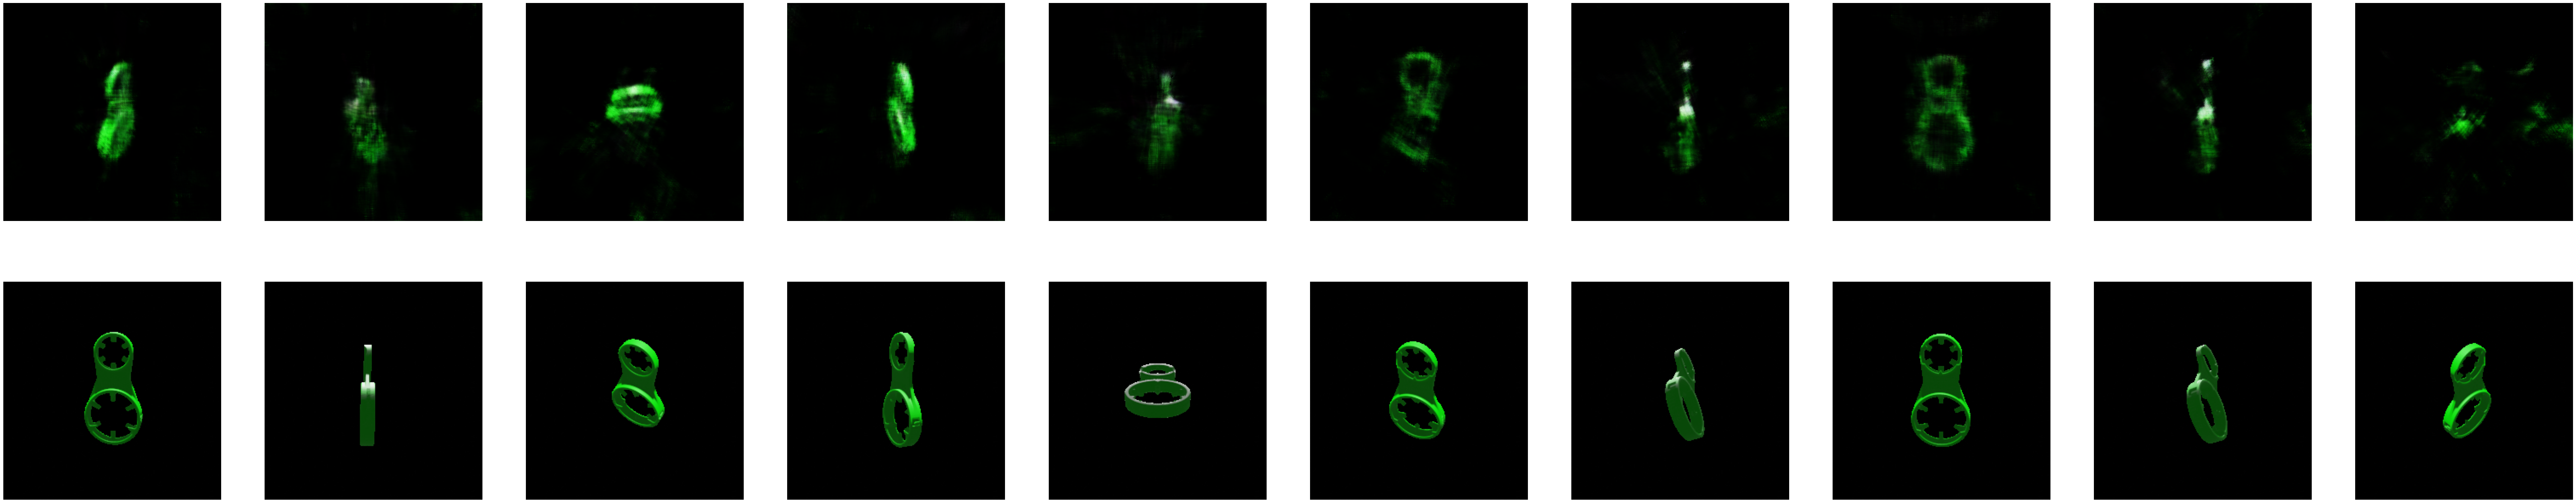

In [25]:
fig, ax = plt.subplots(figsize=(100, 20))
for i in range(len(testImages)):
    plt.subplot(2, 10, i+1)
    plt.imshow(testImages[i])
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(trueTestImages[i])
    plt.axis('off')
plt.show()

<ipython-input-26-65723e865a74>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 10, i+1)


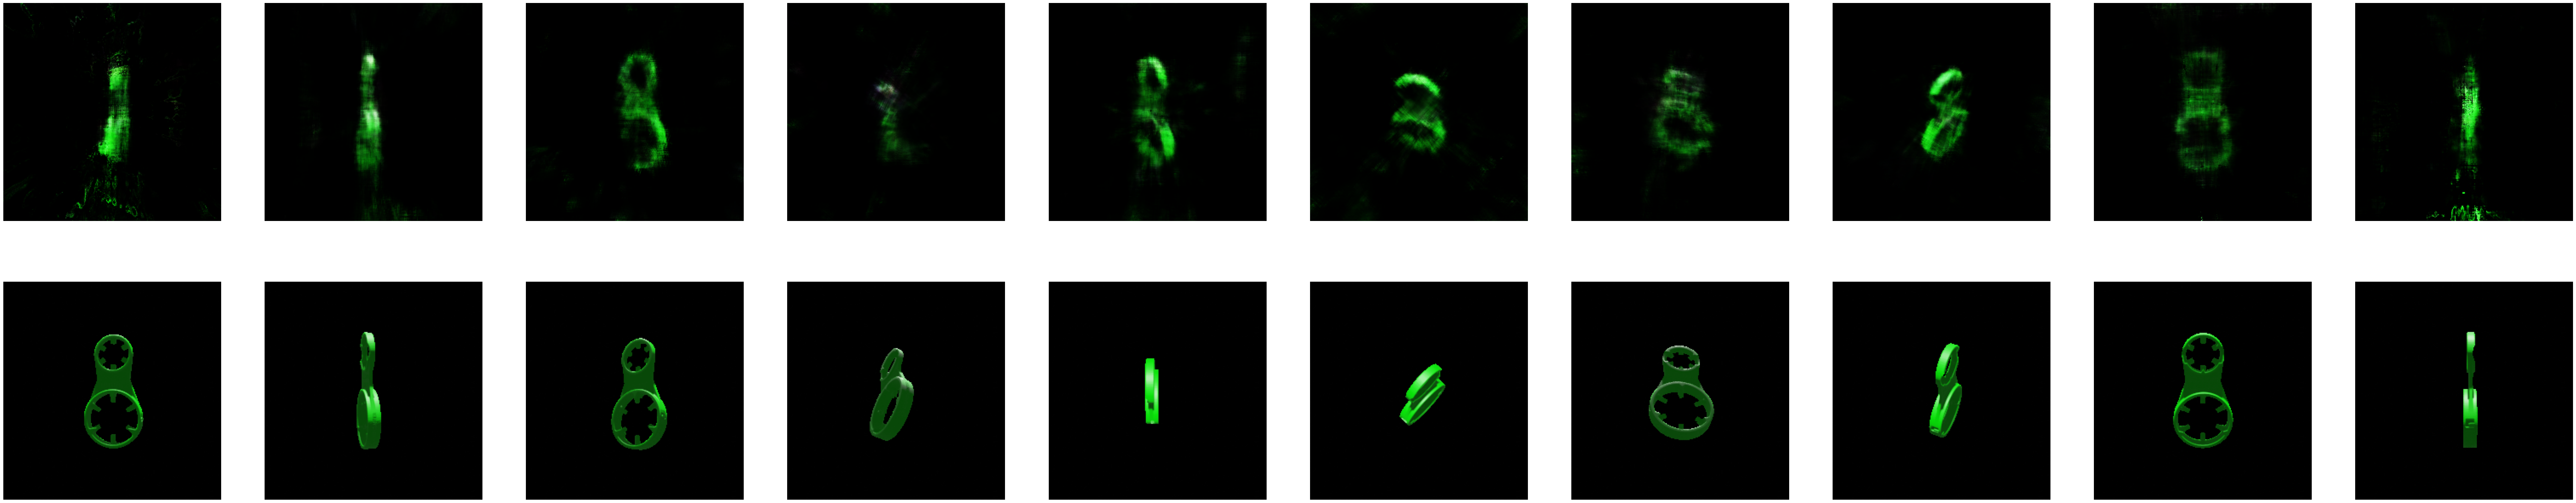

In [26]:
fig, ax = plt.subplots(figsize=(100, 20))
model = [1, 20, 27, 28, 40, 58, 67, 78, 89, 99]
blender = [5, 16, 26, 32, 40, 58, 67, 78, 89, 99]
for i in range(len(testImages)):
    plt.subplot(2, 10, i+1)
    plt.imshow(trainingImages[images[i]])
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(trueTrainImages[images[i]])
    plt.axis('off')
plt.show()